In [24]:
import tritonclient.http as httpclient
import numpy as np
import tritonhttpclient
import sys
import cv2
import matplotlib.pyplot as plt

In [14]:
triton_client = httpclient.InferenceServerClient(url='127.0.0.1:8000', verbose=False)

In [15]:
from tritonclient.utils import InferenceServerException
import tritonclient.http as httpclient

# Create the Triton client
triton_client = httpclient.InferenceServerClient(url='127.0.0.1:8000', verbose=False)

try:
    # Get the list of models
    models = triton_client.get_model_repository_index()

    # Print model names
    for model in models:
        print(f"Model Name: {model['name']}, Version: {model.get('version', 'default')}")

except InferenceServerException as e:
    print("Error communicating with Triton server:", str(e))


Model Name: lprnet, Version: 1
Model Name: ocrnet, Version: 1
Model Name: paddle, Version: 1
Model Name: trocr_python, Version: 1
Model Name: yolo_v4, Version: 2


In [16]:
def yolo_v4(triton_client, image):
    try:
        img = image.copy()
        image = np.array(image).astype(np.float32)

        images = np.array([image])
        images = images[..., [2, 1, 0]]  # RGB -> BGR
        images = images.transpose(0, 3, 1, 2)  # channels_last -> channels_first
        bb, gg, rr = 103.939, 116.779, 123.68
        images -= np.array([[[[bb]], [[gg]], [[rr]]]])

        input0_data = images

        input_byte_size = input0_data.size * input0_data.itemsize

        inputs = []
        inputs.append(tritonhttpclient.InferInput("Input", [1, 3, 768, 1248], "FP32"))
        inputs[-1].set_data_from_numpy(input0_data)

        outputs = []
        outputs.append(tritonhttpclient.InferRequestedOutput('BatchedNMS', binary_data=False))
        outputs.append(tritonhttpclient.InferRequestedOutput('BatchedNMS_1', binary_data=False))
        outputs.append(tritonhttpclient.InferRequestedOutput('BatchedNMS_2', binary_data=False))
        outputs.append(tritonhttpclient.InferRequestedOutput('BatchedNMS_3', binary_data=False))

        results = triton_client.infer(model_name='yolo_v4', inputs=inputs, outputs=outputs)

        output0_data = results.as_numpy('BatchedNMS')
        output1_data = results.as_numpy('BatchedNMS_1')
        output2_data = results.as_numpy('BatchedNMS_2')
        output3_data = results.as_numpy('BatchedNMS_3')

        no_of_bbox = output0_data[0][0]
        confs = output2_data[0]
        coordinates = output1_data[0]
        predicted_class = output3_data[0]

        objects = []

        for i in range(no_of_bbox):
            data = {}
            data['image'] = img[int(img.shape[0]*coordinates[i][1]):int(img.shape[0]*coordinates[i][3]), int(img.shape[1]*coordinates[i][0]):int(img.shape[1]*coordinates[i][2]), :] 
            data['coordinates'] = [int(img.shape[1]*coordinates[i][0]), int(img.shape[0]*coordinates[i][1]), int(img.shape[1]*coordinates[i][2]), int(img.shape[0]*coordinates[i][3])]
            data['class'] = int(predicted_class[i])
            data['conf'] = confs[i]
            objects.append(data)
        
        return objects
    except Exception as ex:
        # Handle exceptions and provide meaningful error messages in the response
        _, _, e_traceback = sys.exc_info()
        filename = e_traceback.tb_frame.f_code.co_filename
        function_name = e_traceback.tb_frame.f_code.co_name
        message = f"At line no {e_traceback.tb_lineno}, in {function_name} of {filename}: {str(ex)}"
        print({"exception": True, "message": message})
        return {"exception": True, "message": message}


946

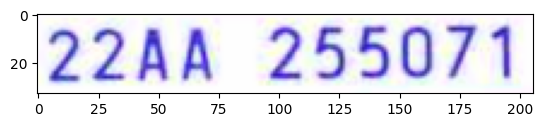

In [25]:
plt.imshow(patch)
plt.show()

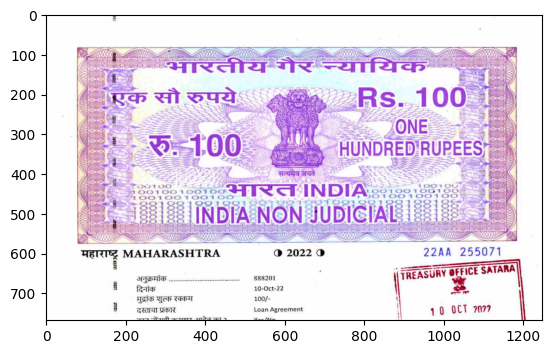

In [26]:
plt.imshow(image)
plt.show()

In [ ]:
import os
import cv2
import csv

# Dummy function signature for reference
# def yolo_v4(triton_client, image): ...

def save_cropped_patches(root_dir, output_base_dir, triton_client):
    failed_images = []

    for root, folders, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.png'):
                input_path = os.path.join(root, file)

                try:
                    image = cv2.imread(input_path)
                    if image is None:
                        raise ValueError("Image is unreadable or None")

                    objects = yolo_v4(triton_client, image)
                    if not objects:
                        raise ValueError("No objects detected")

                    x1, y1, x2, y2 = objects[0]['coordinates']
                    patch = image[y1:y2, x1:x2, :]

                    # Create output path
                    relative_path = os.path.relpath(root, root_dir)
                    output_dir = os.path.join(output_base_dir, relative_path)
                    os.makedirs(output_dir, exist_ok=True)

                    output_path = os.path.join(output_dir, file)
                    success = cv2.imwrite(output_path, patch)
                    if not success:
                        raise IOError("Failed to save image")

                except Exception as e:
                    print(f"[Error] {input_path}: {e}")
                    failed_images.append([input_path, str(e)])

    # Save failed image paths to CSV
    if failed_images:
        with open('failed_images.csv', 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['Image Path', 'Error'])
            writer.writerows(failed_images)

# Usage
root_folder = 'Validation Data-21-04-2025'
patch_folder = 'patches'
save_cropped_patches(root_folder, patch_folder, triton_client)
